In [29]:
import pandas as pd

data = pd.read_csv('C:/Users/Wu/Desktop/uOttawa/MDTI/DTI6997 Research Project/Data Cleaned.csv')
data['Star_rating'] = data['Star_rating'] -1
data

,Unnamed: 0,Content,Star_rating,Rating
0,0,easy website easy website fast shipping wonder...,3,Great
1,1,hey merry christmas nike hey merry christmas n...,0,Bad
2,2,nike along apple coca cola supporting slavery ...,0,Bad
3,3,ordered shoe 16th day ordered shoe 16th day or...,0,Bad
4,4,bad service good product,0,Bad
...,...,...,...,...
231,231,recommend nikecom give nikecom 5 star always s...,4,Excellent
232,232,great shoe jogger,3,Great
233,233,bought expensive running shoe bought expensive...,0,Bad
234,234,ordered lot site ordered lot site always get g...,4,Excellent


In [30]:
Y = pd.get_dummies(data["Star_rating"]).values

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence = data.Content.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(sentence)
padded_sequence = pad_sequences(encoded_docs, maxlen = 300)

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_sequence,Y, test_size = 0.2, random_state = 0)

# LSTM

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

# LSTM model
embedding_vector_length = 32
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_vector_length,  input_length=300) )  
                                    # input_length=padded_sequence.shape[1]) )
model1.add(SpatialDropout1D(0.25))
#model1.add(LSTM(50, return_sequences = True, dropout=0.5, recurrent_dropout=0.5))
model1.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 300, 32)           55904     
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 300, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 255       
                                                                 
Total params: 72,759
Trainable params: 72,759
Non-trainable params: 0
_________________________________________________

In [128]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy')]
model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=2, callbacks = callbacks) 

Epoch 1/10
94/94 [==============================] - 9s 98ms/step - loss: 0.1881 - accuracy: 0.9362 - val_loss: 1.2630 - val_accuracy: 0.6458
Epoch 2/10
94/94 [==============================] - 9s 96ms/step - loss: 0.2872 - accuracy: 0.8989 - val_loss: 1.0833 - val_accuracy: 0.6458


In [129]:
from sklearn import metrics
y_pred = model1.predict(x_test).round()
print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.14      0.25      0.18         4
           4       0.78      0.72      0.75        25

    accuracy                           0.67        48
   macro avg       0.33      0.37      0.34        48
weighted avg       0.65      0.67      0.65        48



C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
from sklearn.metrics import confusion_matrix 
cm_LSTM = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_LSTM

array([[13,  0,  0,  0,  2],
       [ 1,  0,  0,  0,  0],
       [ 1,  0,  0,  2,  0],
       [ 0,  0,  0,  1,  3],
       [ 3,  0,  0,  4, 18]], dtype=int64)

<AxesSubplot:>

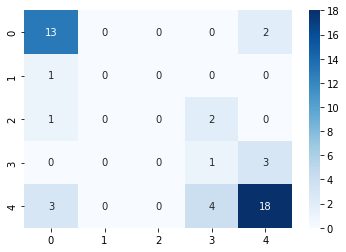

In [131]:
import numpy as np
import seaborn as sns
sns.heatmap(cm_LSTM, annot=True, cmap='Blues')

In [132]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [133]:
# Binarize the output
y_temp = y_test
y_temp = label_binarize(y_temp, classes=[0, 1, 2, 3, 4])
n_classes = y_temp.shape[1]

In [134]:
y_score = y_pred

In [135]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [136]:
from scipy import interp
from numpy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [137]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

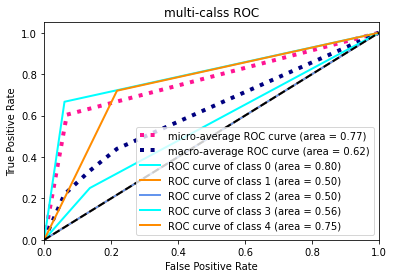

In [138]:
import matplotlib.pyplot as plt
from itertools import cycle
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()

In [103]:
# Bidrectional LSTM
from tensorflow.keras.layers import Bidirectional

embedding_vector_length = 32
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=300) )
model2.add(SpatialDropout1D(0.25))
model2.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [112]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy')]
model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=2, callbacks = callbacks) 

Epoch 1/10
94/94 [==============================] - 17s 181ms/step - loss: 0.0734 - accuracy: 0.9840 - val_loss: 1.5717 - val_accuracy: 0.6250
Epoch 2/10
94/94 [==============================] - 17s 179ms/step - loss: 0.0663 - accuracy: 0.9894 - val_loss: 1.5007 - val_accuracy: 0.7083


In [113]:
from sklearn import metrics
y_pred = model2.predict(x_test).round()
print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.11      0.25      0.15         4
           4       0.83      0.76      0.79        25

    accuracy                           0.71        48
   macro avg       0.36      0.39      0.37        48
weighted avg       0.71      0.71      0.71        48



C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
from sklearn.metrics import confusion_matrix 
cm_LSTM = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_LSTM

array([[14,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0],
       [ 1,  0,  0,  2,  0],
       [ 0,  0,  0,  1,  3],
       [ 0,  0,  0,  6, 19]], dtype=int64)

<AxesSubplot:>

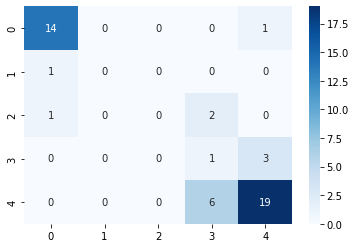

In [115]:
import numpy as np
import seaborn as sns
sns.heatmap(cm_LSTM, annot=True, cmap='Blues')

In [116]:
y_score = y_pred

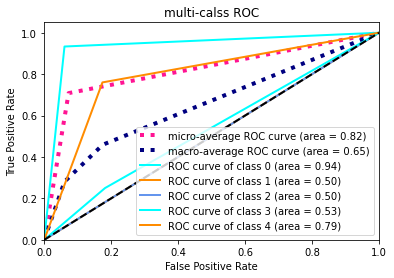

In [117]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
from scipy import interp
from numpy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fpr["micro"], tpr["micro"], _ = roc_curve(y_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

import matplotlib.pyplot as plt
from itertools import cycle
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()

# CNN

In [118]:
# 1D CNN
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D
embedding_vector_length = 32
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_vector_length, input_length=300) )
model3.add(Conv1D(50, 6, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [124]:
callbacks = [EarlyStopping(monitor='val_accuracy')]
model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=2,callbacks= callbacks) 

Epoch 1/5
94/94 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.7128 - val_loss: 0.8796 - val_accuracy: 0.7292
Epoch 2/5
94/94 [==============================] - 0s 2ms/step - loss: 0.5347 - accuracy: 0.7926 - val_loss: 0.8878 - val_accuracy: 0.7083


In [125]:
from sklearn import metrics
y_pred = model3.predict(x_test).round()
print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.93      0.62        15
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.72      0.52      0.60        25

    accuracy                           0.56        48
   macro avg       0.24      0.29      0.25        48
weighted avg       0.52      0.56      0.51        48



C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import confusion_matrix 
cm_CNN = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_CNN

array([[15,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0],
       [23,  0,  0,  0,  2]], dtype=int64)

<AxesSubplot:>

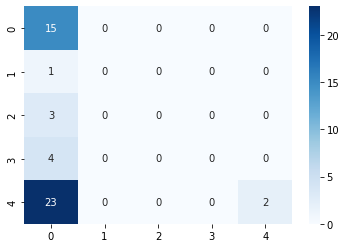

In [21]:
import numpy as np
import seaborn as sns
sns.heatmap(cm_CNN, annot=True, cmap='Blues')

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [23]:
# Binarize the output
y_temp = y_test
y_temp = label_binarize(y_temp, classes=[0, 1, 2, 3, 4])
n_classes = y_temp.shape[1]

In [24]:
y_score = y_pred

In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_temp[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
from scipy import interp
from numpy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [27]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_temp.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

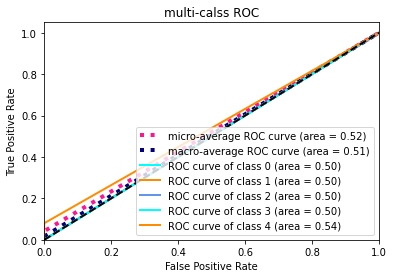

In [28]:
import matplotlib.pyplot as plt
from itertools import cycle
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC')
plt.legend(loc="lower right")
plt.show()